In [62]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
# Import 
import time

In [2]:
df = pd.read_csv('dataset/critics.csv')
df = df[~df.quote.isnull()]
df.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story


In [3]:
n_quotes = len(df)
n_critics = df.rtid.unique().size
n_movie = df.critic.unique().size

print('Number of quotes: %d' %(n_quotes))
print('Number of critics: %d' %(n_critics))
print('Number of movies: %d' %(n_movie))

Number of quotes: 15561
Number of critics: 1921
Number of movies: 623


In [4]:
y = (df.fresh == 'fresh').values.astype(np.int64)

#### Test Bag of Word function in Python

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
sample_text = ['dota too', 'bad dota', 'stupid too']
print('Original Text is:\n', '\n'.join(sample_text))

vectorizer = CountVectorizer(min_df = 0)
vec = vectorizer.fit_transform(sample_text)
vec = vec.toarray()

print('')
print('transformed text vector is: \n', vec)

print('')
print('feature names are: \n', vectorizer.get_feature_names())

Original Text is:
 dota too
bad dota
stupid too

transformed text vector is: 
 [[0 1 0 1]
 [1 1 0 0]
 [0 0 1 1]]

feature names are: 
 ['bad', 'dota', 'stupid', 'too']


In [6]:
def make_bow(df, min_score):
    vectorizer = CountVectorizer(min_df = min_score)
    X = vectorizer.fit_transform(df.quote)
    X = X.toarray()
    y = (df.fresh == 'fresh').values.astype(np.int64)
    
    return X,y    

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

X, y = make_bow(df, 0)
xtrain, xtest, ytrain, ytest = train_test_split(X, y, train_size = 0.8, random_state = 66)

clf = MultinomialNB()
clf.fit(xtrain, ytrain)

print('training accuracy: %0.2f%%' %(clf.score(xtrain, ytrain)*100))
print('training accuracy: %0.2f%%' %(clf.score(xtest, ytest)*100))

training accuracy: 91.87%
training accuracy: 78.00%


In [8]:
from sklearn.model_selection import KFold

def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

def cv_optimize(clf, x, y, score, n_fold):
    
    cv_score = 0
    kf = KFold(n_splits=n_fold)
    for train, valid in kf.split(x):
        clf.fit(x[train], y[train])
        cv_score += score(clf, x[valid], y[valid])
        
    return cv_score / n_fold
    

In [11]:
train, test = train_test_split(range(df.shape[0]), train_size = 0.8, random_state = 66)
mask = np.zeros(df.shape[0])
mask[train] = 1
mask = mask == 1

In [112]:

start_time = time.time()


alpha = [0, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

max_score = -np.inf
best_alpha = 0
best_mindf = 0

for a in alpha:
    for mindf in min_dfs:
        
        vectorize = CountVectorizer(min_df = mindf)
        X = vectorize.fit_transform(df.quote)
        X = X.toarray()
        Y = y
        
        xtrain = X[mask]
        ytrain = Y[mask]
        
        clf = MultinomialNB(alpha = a)

        cvscore = cv_optimize(clf, xtrain, ytrain, log_likelihood, 5)
        
        if cvscore > max_score:
            max_score = cvscore
            best_alpha, best_mindf = a, mindf
            
        print(X.shape)
        
        
# Print the time elapsed.
print((time.time() - start_time))

D:\Anaconda\lib\site-packages\sklearn\naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -


(15561, 22417)
(15561, 12831)
(15561, 2120)
(15561, 203)
(15561, 17)
(15561, 22417)
(15561, 12831)
(15561, 2120)
(15561, 203)
(15561, 17)
(15561, 22417)
(15561, 12831)
(15561, 2120)
(15561, 203)
(15561, 17)
(15561, 22417)
(15561, 12831)
(15561, 2120)
(15561, 203)
(15561, 17)
(15561, 22417)
(15561, 12831)
(15561, 2120)
(15561, 203)
(15561, 17)
130.60085725784302


In [84]:
cvscore, best_alpha, best_mindf

(-1651.5514694824374, 5, 0.001)

In [153]:
from sklearn.metrics import confusion_matrix
X, y = make_bow(df, best_mindf)
xtrain, ytrain, xtest, ytest = X[mask], y[mask], X[~mask], y[~mask]

clf = MultinomialNB(alpha = best_alpha)
clf.fit(xtrain, ytrain)
clf.score(xtest, ytest)

cm = confusion_matrix(ytest, clf.predict(xtest))
print('confusion matrix is: \n', cm)

confusion matrix is: 
 [[ 767  416]
 [ 377 1553]]


#### Interpretation of Results

In [156]:
xtest.shape

(3113, 2120)

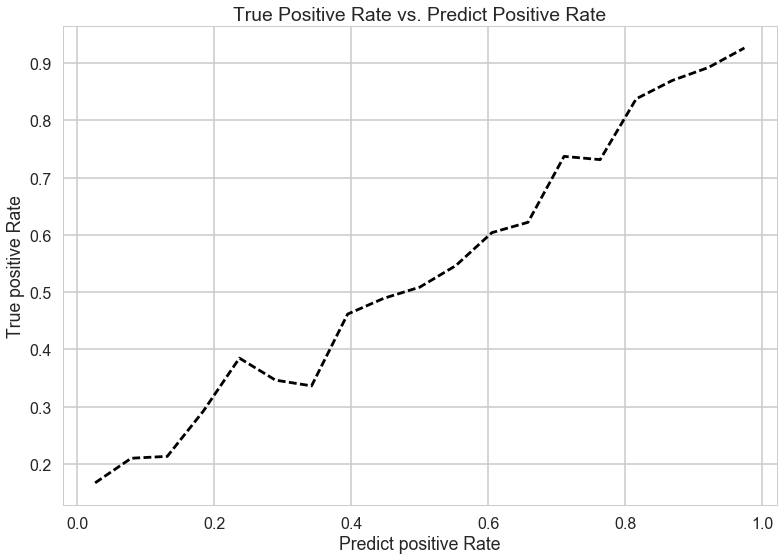

In [157]:
def tp_prediction(clf, xtest, ytest):
    prob = clf.predict_proba(xtest)[:,1]
    outcome = ytest
    data = pd.DataFrame(dict(prob=prob, outcome=outcome))
    
    bins = np.linspace(0,1,20)
    cuts = pd.cut(prob, bins)
    
    cal = data.groupby(cuts).outcome.agg(['mean', 'count'])
    cal['pmid'] = (bins[:-1] + bins[1:]) / 2
    
    plt.plot(cal.pmid, cal['mean'], linestyle = '--', color = 'k')


tp_prediction(clf, xtest, ytest)
plt.ylabel('True positive Rate')
plt.xlabel('Predict positive Rate')
plt.title('True Positive Rate vs. Predict Positive Rate')

In [128]:
vectorize = CountVectorizer(min_df=0.001)
vectorize.fit_transform(df.quote)

<15561x2120 sparse matrix of type '<class 'numpy.int64'>'
	with 211643 stored elements in Compressed Sparse Row format>

In [176]:
start_time = time.time()
word = np.array(vectorize.get_feature_names())

x = np.eye(len(word))
probs = clf.predict_log_proba(x)[:,0]
ind = np.argsort(probs)

good_word = word[ind[:10]]
good_prob = 1- np.exp(probs[ind[:10]])

bad_word = word[ind[-10:]]
bad_prob = 1 - np.exp(probs[ind[-10:]])

print(time.time()-start_time)

0.027036666870117188


In [200]:
print('\tGood Word\t P(fresh | word)')
print('-------------------------------------------')
for w, p in zip(good_word, good_prob):
    print('%20s \t\t %0.2f' 
          %(w, p))
print('-------------------------------------------')    
print('\tBad Word\t P(fresh | word)')
print('-------------------------------------------')
for w, p in zip(bad_word, bad_prob):
    print('%20s \t\t %0.2f' 
          %(w, p))

	Good Word	 P(fresh | word)
-------------------------------------------
             delight 		 0.90
            touching 		 0.90
         masterpiece 		 0.89
              superb 		 0.88
          remarkable 		 0.87
        entertaining 		 0.86
         beautifully 		 0.86
         intelligent 		 0.86
          engrossing 		 0.86
               witty 		 0.86
-------------------------------------------
	Bad Word	 P(fresh | word)
-------------------------------------------
            tiresome 		 0.22
       disappointing 		 0.22
      disappointment 		 0.20
                dull 		 0.20
             unfunny 		 0.19
               bland 		 0.18
          uninspired 		 0.18
       unfortunately 		 0.17
           pointless 		 0.17
                lame 		 0.15


In [203]:
X, y = make_bow(df, 0.001)   

In [281]:
probs = clf.predict_log_proba(X)[:,0]
predict = clf.predict(X)

In [299]:
probs[y==1][3965]

-0.000973105517886097

In [282]:
pf_br = np.argsort(probs[y == 0])[:5]
pr_bf = np.argsort(probs[y == 1])[-5:]

In [304]:
for numb in pf_br:
    print(numb)
    print(df[y==0]['quote'].irow(numb))
    
for num in pr_bf:
    print(num)
    print(df[y==1]['quote'].irow(num))
    

2149
It survives today only as an unusually pure example of a typical 50s art-film strategy: the attempt to make the most modern and most popular of art forms acceptable to the intelligentsia by forcing it into an arcane, antique mold.
3789
Part comedy, part family drama, part romance, part special-effects mystery-adventure, and not entirely satisfying on any of these levels.
5411
This pacifist spirit of brotherhood echoes the heroics in Princess Mononoke and other anime titles, but the artistic gap between the Miyazaki masterpiece and this project is huge.
5838
Benefits from a lively lead performance by the miscast Denzel Washington but doesn't come within light years of the book, one of the greatest American autobiographies.
4577
The thought that he may yet return for further adventures with his body and Lugosi's sconce fills us with mortal terror. That is the most fearful prospect which the picture manages to convey.
1177
The gangland plot is flimsy (bad guy Peter Greene wears too m

D:\Anaconda\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: irow(i) is deprecated. Please use .iloc[i] or .iat[i]
  app.launch_new_instance()
D:\Anaconda\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: irow(i) is deprecated. Please use .iloc[i] or .iat[i]


In [294]:
df[y==0].quote.irow(4577)

D:\Anaconda\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: irow(i) is deprecated. Please use .iloc[i] or .iat[i]
  if __name__ == '__main__':


"The thought that he may yet return for further adventures with his body and Lugosi's sconce fills us with mortal terror. That is the most fearful prospect which the picture manages to convey."

In [291]:
df.quote.iloc[4577]

"The thought that he may yet return for further adventures with his body and Lugosi's sconce fills us with mortal terror. That is the most fearful prospect which the picture manages to convey."

In [295]:
df[y==0].iloc[4577,:]

critic                                           Bosley Crowther
fresh                                                     rotten
imdb                                                       34786
publication                                       New York Times
quote          The thought that he may yet return for further...
review_date                                           2006-03-25
rtid                                                   770797457
title                                  The Ghost of Frankenstein
Name: 22036, dtype: object

In [230]:
df.quote.shape

(15561,)

In [292]:
df.quote[17000]

KeyError: 17000